Complete the exercises below For **Assignment #6**.

Import the following items,
- `pandas as pd`,
- `LinearRegression` from the [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module,
- `make_column_transformer` from [`sklearn.compose`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose),
- `OneHotEncoder` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing),
- `make_pipeline` from the [`sklearn.pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) module, and,
- everything from the [plotnine]() package.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from plotnine import *

## Read in our data for this exercise

Use `pd.read_csv` to read in data from the following URL: http://bit.ly/2IgDF0E. Capture the data into a dataframe called `df_voles`.

❗️Hint: just like in `R` we can read data directly from a URL.

In [2]:
df_voles = pd.read_csv('http://bit.ly/2IgDF0E')

Preview the data with the `.head()` method.

The data contains the variables:

- `site` for the id of each random study site (each case or row is a survey/trapping site)
- `voles` for the vole count at each site
- `veg` for the percent cover of vegetation at each site
- `soil` identifying a site as “moist” or “dry”

In [3]:
df_voles.head()

,site,voles,veg,soil
0,1,17,4,moist
1,2,30,33,moist
2,3,54,94,moist
3,4,49,64,moist
4,5,34,32,moist


## EDA

Let's make a few figures from `df_voles` using `ggplot` from **Plotnine**.

In the cell below plot the `voles` variable (y-axis) versus the `veg` variable and color points by the `soil` variable.

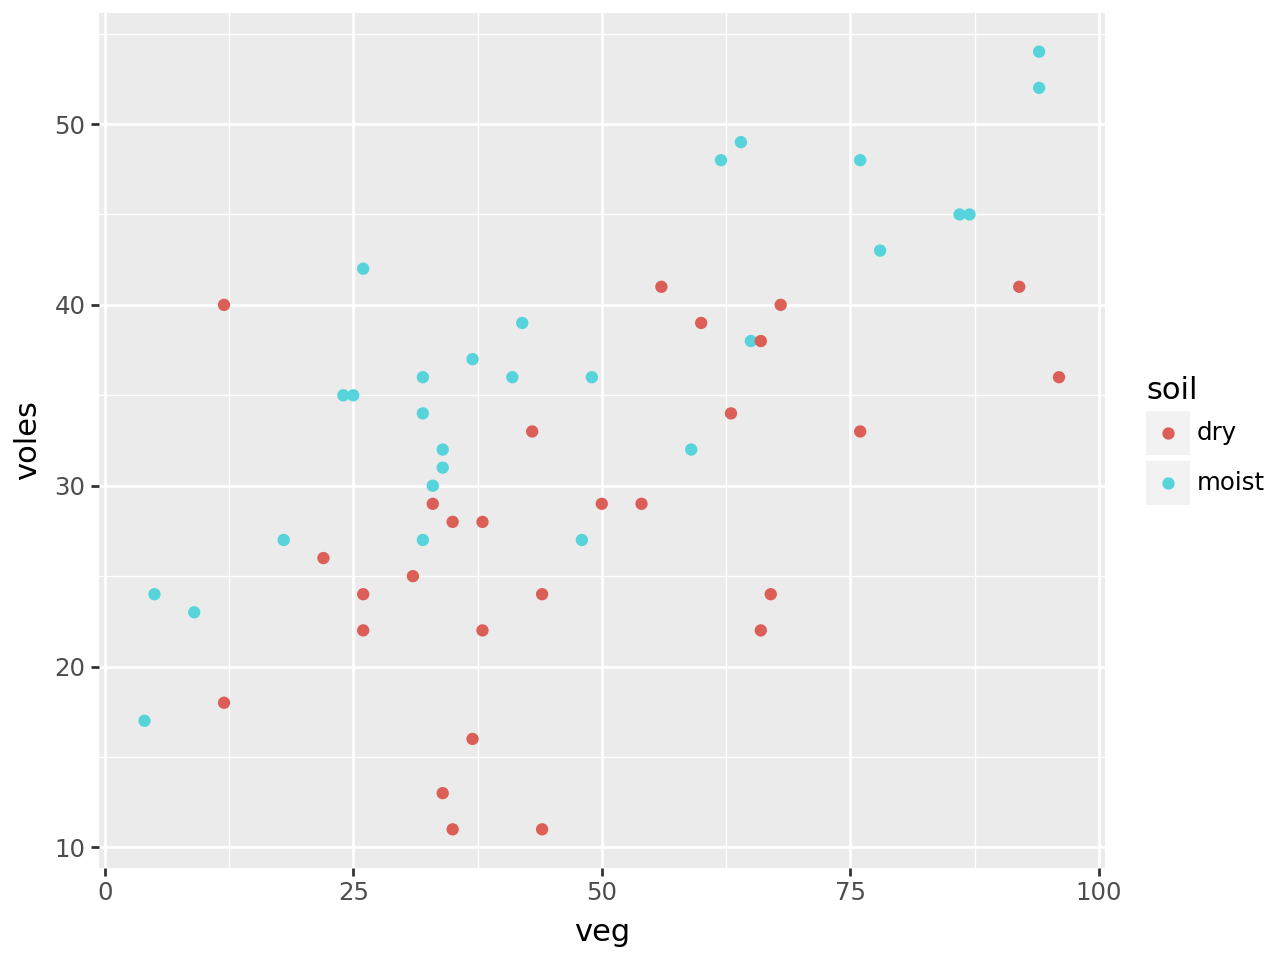

In [4]:
(
    ggplot(df_voles, aes(x = "veg", y = "voles", color = "soil")) 
     + geom_point()
)

## Modeling

In the cell below, model `voles` with `soil` and `veg` as predictors in a parallel slopes model. 

Here are the steps I would take:
1. Make a column transformer with `make_column_transformer` that transforms `soil` with `OneHotEncoder(drop="first")` and passes 'veg' through untransformed.
2. Create a pipeline with `make_pipeline` using the column transformer from above and `LinearRegression()` as my model. 
3. Get the `X` (training data) and `y` predictor from `df_voles`
4. Use the `.fit()` method for the pipeline to train the model with `X` and `y`. 

In [5]:
### Making a column transformer that transforms soil and passes through veg.
column_transformer = make_column_transformer((OneHotEncoder(drop = "first"), ["soil"]), ("passthrough", ["veg"]))

### Creating a pipeline using the column_transformer we created above with the LinearRegression() model.
pipeline = make_pipeline(column_transformer, LinearRegression())

### Getting the training data (predictors and target data) from df_voles.
X = df_voles[["soil", "veg"]]
y = df_voles["voles"]

### Training the model with X and y using the fit() method.
pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['soil']),
                                                 ('passthrough', 'passthrough',
                                                  ['veg'])])),
                ('linearregression', LinearRegression())])

Use the function below to get the parameter values for your model from above.

In [6]:
def get_regression_table(pipeline):
    terms=list(pipeline['columntransformer'].get_feature_names_out()) + ['intercept']
    mod = pipeline['linearregression']
    estimates = list(mod.coef_) + [mod.intercept_]
    data = dict(
        term=terms, 
        estimate=estimates,
    )
    return pd.DataFrame(data)

In [7]:
regression_table = get_regression_table(pipeline)
regression_table

,term,estimate
0,onehotencoder__soil_moist,9.100298
1,passthrough__veg,0.259069
2,intercept,15.464026


❓Would protecting a site with high vegetation cover be a more effective way to preserve the vole population than a site with low vegetation cover? Why?

(**Hint:** use your chart above to answer. It's also possible to leverage your regression parameters if you chose to model `voles` with a parallel slopes model.)

**Answer:** Yes, protecting a site with a higher vegetation coverage would be more effeective with preserving the vole population. For every 1 percent increase of vegetation coverage, we can expect to see the vole population increase by around .26 voles. 

❓Dry sites typically cost a lot less to purchase and maintain for conservation organizations. Thus, if a conservation organization decides to purchase a few dry sites, roughly what percent cover of vegetation do they need to maintain on these sites (at a minimum) to support a population of about 30 voles at the site?

(**Hint:** In your chart above, draw a line at voles = 30 using `geom_hline` and make a rough estimate for this answer...)

**Answer:** Based on looking at the chart below, the bare minimum percentage of vegetation for dry soil to maintain a vole population of 30 is around 57% (roughly). We are looking for where on the x axis the line for dry soil intersects with the horizontal line representing 30 voles.

We can also use the regression table to solve using the formula and algebra.
      
voles = intercept + .259069 * veg       
30 = 15.464026 + .259069 * veg      
veg = 56.1085      

This aligns with what we say looking at the plot, but getting a more accurate answer instead of "eyeballing" it.

To take it a step further we can use the predict function (from the next question) .predict(pd.DataFrame({"soil": ["moist"], "veg": [40]})) with our pipline to confirm that the value we found works to get the minimum vole population of 30 voles.

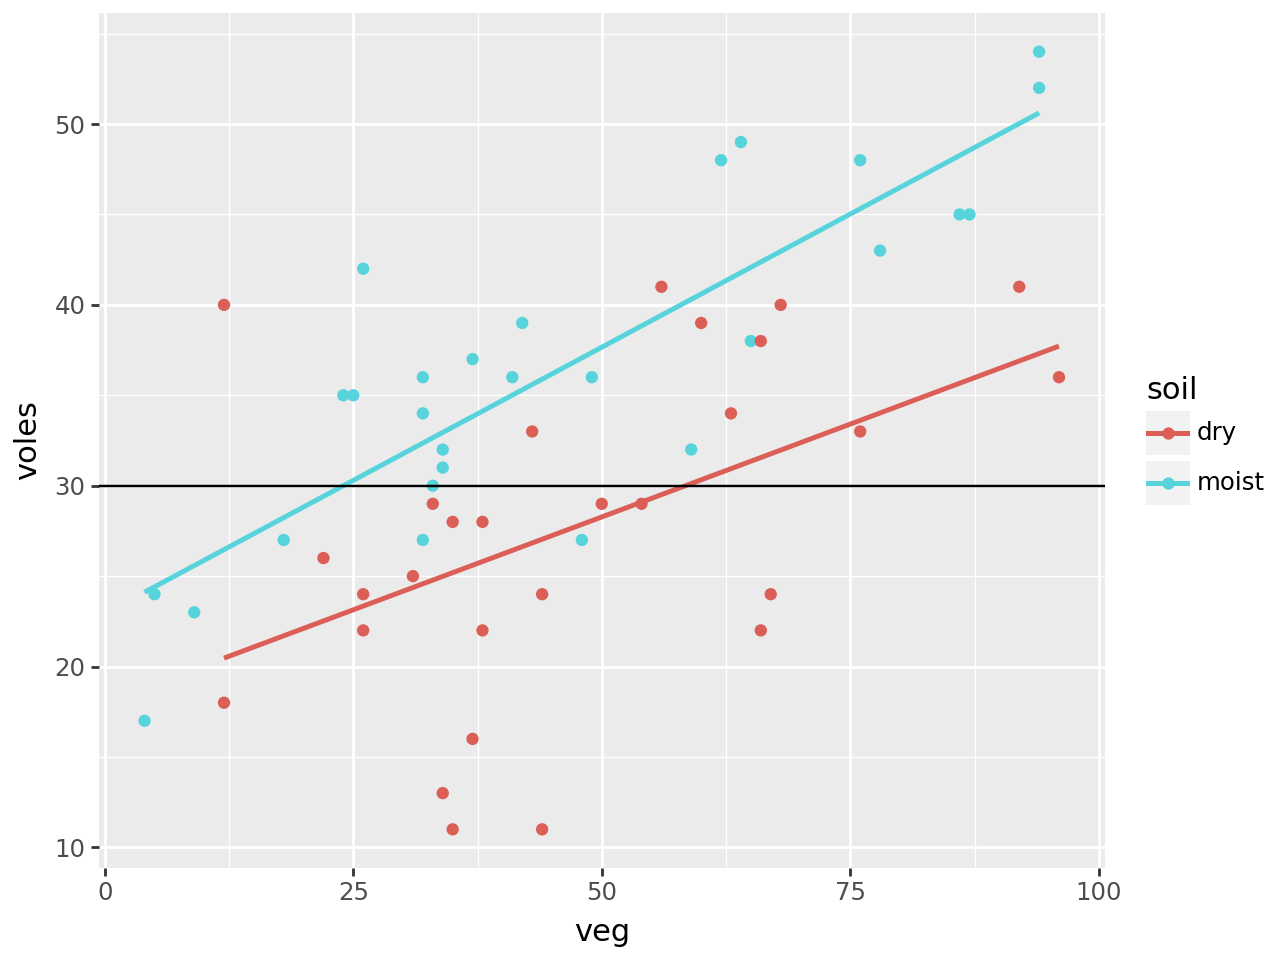

In [8]:
(
    ggplot(df_voles, aes(x = "veg", y = "voles", color = "soil")) 
    + geom_point()
    + geom_smooth(method = "lm", se = False)
    + geom_hline(yintercept = 30)
)

In [9]:
pipeline.predict(pd.DataFrame({"soil": ["dry"], "veg": [56.1085]}))

array([29.99999535])

❓The Nature Conservancy is looking at purchasing a site for this species (in the same study area) that has moist soil and 40% vegetation cover. Using the regression equation what would you predict as the possible vole population the site might be able to support?

(**Hint:** Use `.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))` with yout pipeline.)

**Answer:** The site with moist soil and a vegetation coverage of 40% can expect a vole population of around 35 voles based on using the predict method with our pipeline. 


We can also use the regression equation and algebra to solve for this.
    
voles = intercept + moist + .259069 * veg    
voles = 15.464026 + 9.10298 + .259069 * 40    
voles = 34.93   

This confirms that based on the conditions previously mentioned, we can expect a vole population of around 35 voles.

In [10]:
pipeline.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))

array([34.92708151])